In [1]:
from sklearn.datasets import load_boston
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def binary_predict(x,W):
    x = np.hstack((np.ones((x.shape[0], 1)), x))
    Y = sigmoid(np.dot(x, W))
    Y[Y < 0.5] = 0
    Y[Y >= 0.5] = 1
    return Y

In [3]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

In [4]:
def binary_class_logistic_regression(x, y, num_steps):
    x_train = np.hstack((np.ones((x.shape[0], 1)), x))
    N, d = x_train.shape
    W = np.zeros((d,1))
    for step in range(num_steps):
        mu = sigmoid(np.dot(x_train, W))
        R = np.zeros((N,N)) 
        for i in range(N):
            R[i,i] = mu[i] * (1 - mu[i])
        XRX = np.matmul(x_train.T, np.matmul(R,x_train))
        XRX_pinv = np.linalg.pinv(XRX) 
        z = np.dot(x_train, W) - np.linalg.pinv(R).dot(mu - y.reshape(N,1))
        W = np.dot(XRX_pinv, np.dot(x_train.T, np.dot(R, z)))
    return W.flatten()

In [5]:
def softmax(x):
    e = np.exp(x - np.max(x)) 
    return e / np.array([np.sum(e, axis=1)]).T 

In [6]:
def multi_predict(x,W):
    x = np.hstack((np.ones((x.shape[0], 1)), x))
    Y = softmax(np.dot(x, W))
    Y = np.argmax(Y, axis=1)
    return Y

In [7]:
def multi_class_logistic_regression(x, y, num_steps):
    x_train = np.hstack((np.ones((x.shape[0], 1)), x))
    N, d = x_train.shape
    n_labels = len(np.unique(y))
    W = np.zeros((d,n_labels))
    Y_1_hot = np.eye(n_labels)[y]
    for step in range(num_steps):
        mu = softmax(np.dot(x_train, W))
        R = mu * (1 - mu) 
        for i in range(n_labels):
            R_i = np.diag(R[:,i])
            W[:,i] = W[:,i] - np.linalg.pinv(np.dot((x_train.T).dot(R_i),x_train)).dot(x_train.T).dot(mu[:,i]-Y_1_hot[:,i])
    return W

In [8]:
def evaluate_binary(X_train,Y_train,X_test,Y_test):
    W = binary_class_logistic_regression(X_train,Y_train,6)
    Y = binary_predict(X_test,W)
    test_error = sum(Y_test!=Y)/len(Y_test)
    return test_error

In [9]:
def evaluate_multi(X_train,Y_train,X_test,Y_test):
    W = multi_class_logistic_regression(X_train,Y_train,2)
    Y = multi_predict(X_test,W)
    test_error = sum(Y_test!=Y)/len(Y_test)
    return test_error

In [10]:
def _split_dataset(dataset, train_set_size):
    N = dataset.shape[0]
    split_dataset = np.array(np.array_split(dataset, [int(train_set_size * N)]))
    return split_dataset

In [11]:
# filename = 'boston.csv'
# num_splits = 10
# train_percent = [10, 25, 50, 75, 100]
def boston_logistic_regression(filename,num_splits,train_percent):
    error = np.zeros((num_splits,len(train_percent)))
    bos = pd.read_csv(filename)
    X_arr = bos.iloc[:,0:bos.shape[1]-1].values
    Y_arr = bos.iloc[:,-1].values
    p = np.percentile(Y_arr, 50)
    Y_arr[Y_arr < p] = 0
    Y_arr[Y_arr >= p] = 1
    s = np.arange(len(X_arr))
    n_classes = 2
    for i in range(num_splits):
        np.random.shuffle(s)
        X_cv = X_arr[s]
        Y_cv = Y_arr[s]
        dataset = np.column_stack((X_cv,Y_cv))
        split_dataset = []
        for k in range(n_classes):
            split_class_dataset = _split_dataset(dataset[Y_cv==k],0.8)
            split_dataset.append(split_class_dataset)
        train_data = []
        test_data = []
        for data in split_dataset:
            train_data.append(data[0])
            test_data.append(data[1])
        training_data = np.vstack(train_data) 
        test_data = np.vstack(test_data)
        t = np.arange(len(training_data))
        np.random.shuffle(t)
        training_data = training_data[t]
        u = np.arange(len(test_data))
        np.random.shuffle(u)
        test_data = test_data[u]
        X_test, Y_test = test_data[:,:-1], test_data[:,-1]
        print("=========================Evaluation for split: ",i,"========================")
        for idx,percent in enumerate(train_percent):
            X_train, Y_train = training_data[0:int(percent*len(training_data)/100),:-1], training_data[0:int(percent*len(training_data)/100),-1]
            error[i,idx] = evaluate_binary(X_train,Y_train,X_test,Y_test)
            print("Test error for ",percent,"% training:",error[i,idx])
    print("========Mean test error rate across all splits for training percentage:")
    mean_error = np.mean(error,axis=0)
    for i in range(len(train_percent)):
        print(train_percent[i],"% ==>", mean_error[i])
    std_dev = np.std(error,axis=0)
    fig, axs = plt.subplots(nrows=1, ncols=2)
    ax = axs[0]
    ax.plot(train_percent, mean_error)
    ax.set_title('Mean error vs training percentage')
    ax = axs[1]
    ax.plot(train_percent, std_dev)
    ax.set_title('Standard deviation')
    plt.show()

In [12]:
# filename = 'digits.csv'
# num_splits = 10
# if re.compile(".*digits.*").match(filename):
def digits_logistic_regression(filename,num_splits,train_percent):
    error = np.zeros((num_splits,len(train_percent)))
    digits = pd.read_csv(filename)
    X = digits.iloc[:,0:digits.shape[1]-1].values
    Y = digits.iloc[:,-1].values
    n_labels = len(np.unique(Y))
    s = np.arange(len(X))
    n_classes = n_labels
    for i in range(num_splits):
        np.random.shuffle(s)
        X_cv = X[s]
        Y_cv = Y[s]
        dataset = np.column_stack((X_cv,Y_cv))
        split_dataset = []
        for k in range(n_classes):
            split_class_dataset = _split_dataset(dataset[Y_cv==k],0.8)
            split_dataset.append(split_class_dataset)
        train_data = []
        test_data = []
        for data in split_dataset:
            train_data.append(data[0])
            test_data.append(data[1])
        training_data = np.vstack(train_data) 
        test_data = np.vstack(test_data)
        t = np.arange(len(training_data))
        np.random.shuffle(t)
        training_data = training_data[t]
        u = np.arange(len(test_data))
        np.random.shuffle(u)
        test_data = test_data[u]
        X_test, Y_test = test_data[:,:-1], test_data[:,-1]
        print("=========================Evaluation for split: ",i,"========================")
        for idx,percent in enumerate(train_percent):
            X_train, Y_train = training_data[0:int(percent*len(training_data)/100),:-1], training_data[0:int(percent*len(training_data)/100),-1]
            error[i,idx] = evaluate_multi(X_train,Y_train,X_test,Y_test)
            print("Test error for ",percent,"% training:",error[i,idx])
    print("========Mean test error rate across all splits for training percentage:")
    mean_error = np.mean(error,axis=0)
    for i in range(len(train_percent)):
        print(train_percent[i],"% ==>", mean_error[i])
    std_dev = np.std(error,axis=0)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes[0]
    ax.plot(train_percent, mean_error)
    ax.set_title('Mean error vs training percentage')
    ax = axes[1]
    ax.plot(train_percent, std_dev)
    ax.set_title('Standard deviation')
    plt.show()

In [13]:
def logisticRegression(filename,num_splits,train_percent):
    import re
    if re.compile(".*boston.*").match(filename):
        boston_logistic_regression(filename,num_splits,train_percent)
    if re.compile(".*digits.*").match(filename):
        digits_logistic_regression(filename,num_splits,train_percent)

=========================Evaluation for split:  0 ========================
Test error for  10 % training: 0.19607843137254902
Test error for  25 % training: 0.21568627450980393
Test error for  50 % training: 0.12745098039215685
Test error for  75 % training: 0.12745098039215685
Test error for  100 % training: 0.1568627450980392
=========================Evaluation for split:  1 ========================
Test error for  10 % training: 0.2647058823529412
Test error for  25 % training: 0.22549019607843138
Test error for  50 % training: 0.18627450980392157
Test error for  75 % training: 0.16666666666666666
Test error for  100 % training: 0.18627450980392157
========Mean test error rate across all splits for training percentage:
10 % ==> 0.2303921568627451
25 % ==> 0.22058823529411764
50 % ==> 0.1568627450980392
75 % ==> 0.14705882352941174
100 % ==> 0.1715686274509804


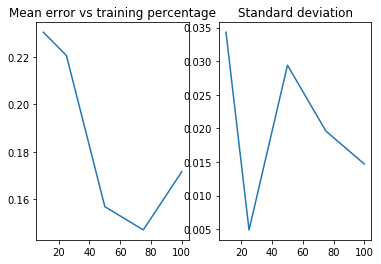

In [15]:
if __name__ == '__main__':
    import sys
    num_splits = 2
    train_set_percentages = [10, 25, 50, 75, 100]
    filename = 'boston.csv' #sys.argv[1]
    try:
        num_splits = int(sys.argv[2])
        train_set_percentages = [int(x) for x in sys.argv[3].split(',')]
    except:
        pass
    logisticRegression(filename, num_splits, train_set_percentages)

In [16]:
pwd

'C:\\Users\\manis'